In [1]:
import raman_rabi
from raman_rabi import rr_model
from raman_rabi import rr_io
from raman_rabi import RRDataContainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import warnings
#warnings.filterwarnings("error")

## Here is for the mN = +1 data

In [20]:
#import mN=+1 data
data_length = 20
testfilepath = rr_io.get_example_data_file_path('21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt')
mN1_data = RRDataContainer(testfilepath)
#print(mN1_data.get_df())

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest

In [4]:
#Estimates from Cluster MCMC
#params= np.array([8.36254404e+00, 2.70752593e+01, 1.62175302e-02, 8.43378839e+00, -3.24751892e-01, 1.33240464e-01])
params = np.array([6.10, 16.6881, 1/63.8806, 5.01886, -np.pi/8.77273, 1/8.5871])
theta = np.concatenate( (params, skew_value_params), axis=0)
param_length = len(theta)
dataN = 10
runN = 1200
gaus_var = 10**(-3)

laserskew_priors = [  ['uniform',0,+np.inf], # BG
                      ['uniform',0,+np.inf], # Ap
                      ['uniform',0.0,+np.inf], # Gammap
                      ['uniform',0,+np.inf], # Ah
                      ['uniform',-np.inf, 0],# Omegah
                      ['uniform',0.0,+np.inf]] # Gammadeph

laserskew_priors = laserskew_priors + [['uniform',0,1]]*data_length

# run MCMC on the test data and see if it's pretty close to the original theta
guesses = theta
numdim = len(guesses)
numwalkers = 200
numsteps = 10000
test_samples = rr_model.Walkers_Sampler(mN1_data, guesses, 0, 40, True, dataN, runN, gaus_var, numwalkers, numsteps, scale_factor=100*100, withlaserskew = True, priors=laserskew_priors)
#test_samples = rr_model.Walkers(mN1_data, guesses,0, 40, True, dataN, runN, scale_factor=100*100,nwalkers=numwalkers,nsteps=numsteps)
burn_in_time = 9500
samples = test_samples.chain[:,burn_in_time:,:]
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

/home/taylor/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/taylor/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Guess Parameters
[ 6.10000000e+00  1.66881000e+01  1.56542049e-02  5.01886000e+00
 -3.58108896e-01  1.16453750e-01]
MCMC Parameters
[ 8.11657984e+00  2.75950091e+01  1.59894439e-02  8.43397937e+00
 -3.25757427e-01  1.32811127e-01]

Estimated Laserskew
[0.72399672 0.75163799 0.4608927  0.6089271  0.90601965 0.78624078
 0.54033579 0.53583129 0.85667485 0.92424241 0.72481573 0.75696151
 0.72788697 0.81040131 0.67915643 0.59193284 1.         0.83579032
 0.68837019 0.82739559]
MCMC Laserskew
[0.72324052 0.76078672 0.47964171 0.63165132 0.88592081 0.79030843
 0.56726133 0.56032156 0.84470484 0.91061846 0.73894657 0.78225742
 0.73335836 0.80195926 0.6868866  0.59689468 0.96237486 0.82905969
 0.68034002 0.82883719]



In [ ]:
#%debug

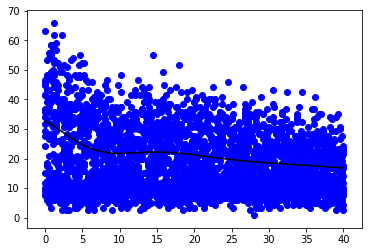

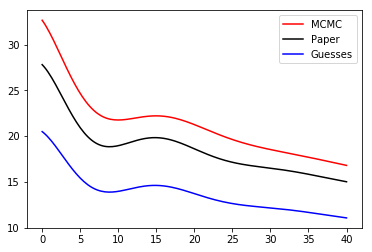

In [5]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #MOST IMPORTANT PART!!!!
#we multiply mu by the 50th percentile
#mean of laser skew

scale_factor = 100*100
N_value = 10

#Plot over unaveraged data
plt.figure()
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/N_value, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

(100000, 6)
500
100000
(200, 10000, 26)


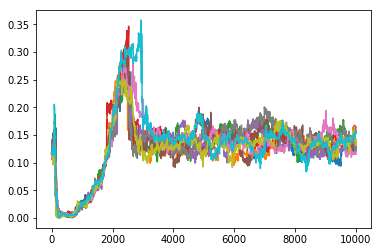

In [12]:
#Look at burn in. This isn't a very realistic set up, we start with good parameters and
#then only let the walkers walk a little while
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples.chain.shape)

param1 = 5

for iii in range(10):
    plt.plot(test_samples.chain[iii, :, param1])

## Here is for the mN = 0 Data

In [21]:
#import mN=+0 data
data_length = 30
testfilepath = rr_io.get_example_data_file_path('23.33.41_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout- -800 MHz, ND0.7 Vel1, Presel 5 (APD2, Win 3)_ID10718_image.txt')
mN1_data = RRDataContainer(testfilepath)
print(mN1_data.get_df())

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest

        0        1        2        3        4        5        6        7    \
0   0.02125  0.01625  0.02250  0.03250  0.01000  0.03125  0.02875  0.05125   
1   0.02875  0.04500  0.02625  0.01875  0.01500  0.03125  0.02875  0.03500   
2   0.03750  0.03000  0.01250  0.02000  0.01625  0.01250  0.01625  0.01625   
3   0.05250  0.03000  0.02125  0.01875  0.03000  0.03375  0.04125  0.01750   
4   0.03250  0.05250  0.02125  0.03250  0.02750  0.01750  0.03500  0.01625   
5   0.06125  0.02000  0.02500  0.00625  0.01625  0.02875  0.04250  0.03000   
6   0.04000  0.03500  0.02500  0.05125  0.05125  0.02875  0.06500  0.04375   
7   0.03250  0.05375  0.03625  0.05625  0.02250  0.03750  0.02125  0.05500   
8   0.01750  0.02250  0.03625  0.02500  0.01375  0.02375  0.02375  0.02000   
9   0.04250  0.02750  0.02500  0.03000  0.03625  0.01875  0.00500  0.04250   
10  0.04750  0.04000  0.03250  0.00750  0.04250  0.02500  0.01875  0.06500   
11  0.02000  0.03250  0.01875  0.02000  0.02250  0.02250  0.0325

In [25]:
#Estimates from Cluster MCMC
#params= np.array([8.36254404e+00, 2.70752593e+01, 1.62175302e-02, 8.43378839e+00, -3.24751892e-01, 1.33240464e-01])
params = np.array([32.589, -20.6311, 1/89.7832, -2.8444, -np.pi/9.37905, 1/7.43712])
theta = np.concatenate( (params, skew_value_params), axis=0)
param_length = len(theta)
dataN = 30
runN = 2400
gaus_var = 10**(-3)

laserskew_priors = [  ['uniform',0,+np.inf], # BG
                      ['uniform',-np.inf, 0], # Ap
                      ['uniform',0.0,+np.inf], # Gammap
                      ['uniform',-np.inf, 0], # Ah
                      ['uniform',-np.inf, 0],# Omegah
                      ['uniform',0.0,+np.inf]] # Gammadeph

laserskew_priors = laserskew_priors + [['uniform',0,1]]*data_length

# run MCMC on the test data and see if it's pretty close to the original theta
guesses = theta
numdim = len(guesses)
numwalkers = 200
numsteps = 500
test_samples = rr_model.Walkers_Sampler(mN1_data, guesses, 0, 40, True, dataN, runN, gaus_var, numwalkers, numsteps, scale_factor=100*100, withlaserskew = True, priors=laserskew_priors)
#test_samples = rr_model.Walkers(mN1_data, guesses,0, 40, True, dataN, runN, scale_factor=100*100,nwalkers=numwalkers,nsteps=numsteps)
burn_in_time = 200
samples = test_samples.chain[:,burn_in_time:,:]
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

/home/taylor/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/taylor/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Guess Parameters
[ 3.25890000e+01 -2.06311000e+01  1.11379412e-02 -2.84440000e+00
 -3.34958514e-01  1.34460651e-01]
MCMC Parameters
[ 32.40763005 -20.74631965   0.11831396  -2.72899446  -0.38131637
   0.10644258]

Estimated Laserskew
[0.61733484 0.75646707 0.63320622 0.45831186 0.55817788 0.69473359
 1.         0.83530867 0.51757188 0.40647223 0.70658559 0.3972998
 0.52416778 0.73564877 0.56776255 0.69947439 0.6253736  0.6593837
 0.60105122 0.49190972 0.56951458 0.63258786 0.41976708 0.30980109
 0.50912089 0.71596413 0.83108317 0.82304442 0.7571885  0.88962177]
MCMC Laserskew
[0.59415028 0.79740431 0.67716785 0.50764671 0.58267505 0.75564702
 0.92964606 0.85133395 0.59002947 0.49590892 0.73322121 0.47176962
 0.57408059 0.71408681 0.6306242  0.70267218 0.7035352  0.67505924
 0.66868999 0.56931005 0.61948457 0.6999039  0.4992619  0.33138108
 0.57077113 0.75720895 0.84317448 0.82508541 0.77432885 0.88263556]

